In [12]:
import numpy as np
import pandas as pd

In [13]:
df=pd.read_csv(r"C:\Users\MAITHILI\Gen-AI_FraudGuard\Datasets\paysim_sample.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
1,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
2,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
3,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
4,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0


In [14]:
df.isnull().sum()  #no null values

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [15]:
df["isFraud"].value_counts()

isFraud
0    149808
1       192
Name: count, dtype: int64

In [16]:
df['isFlaggedFraud'].value_counts()      #only 1 is flagged fraud

isFlaggedFraud
0    149999
1         1
Name: count, dtype: int64

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


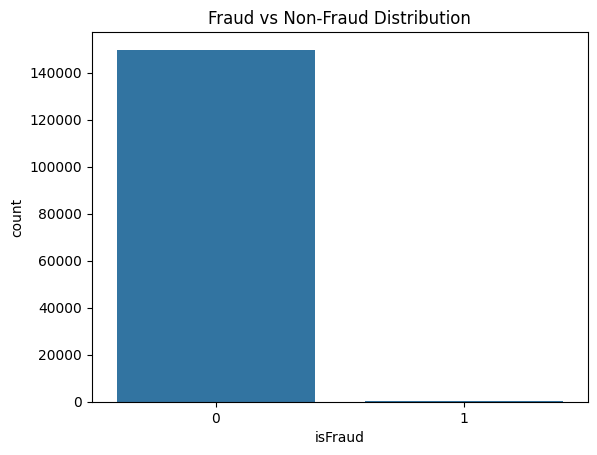

In [18]:
plt.figure()
sns.countplot(x="isFraud", data=df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()
#its very low

In [20]:
print("\nFraud by transaction type:")
print(pd.crosstab(df["type"], df["isFraud"]))



Fraud by transaction type:
isFraud       0    1
type                
CASH_IN   33214    0
CASH_OUT  52732   83
DEBIT       928    0
PAYMENT   50582    0
TRANSFER  12352  109


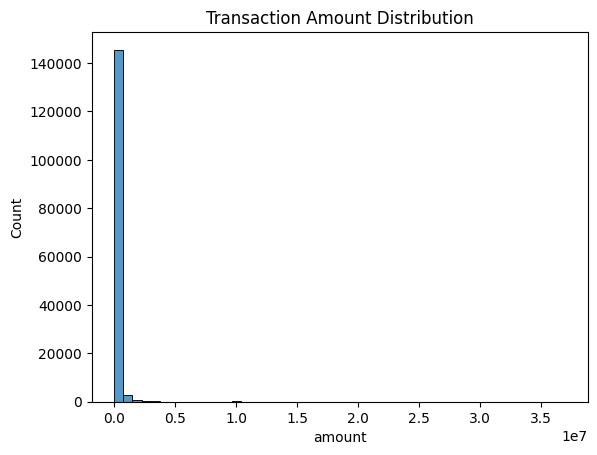

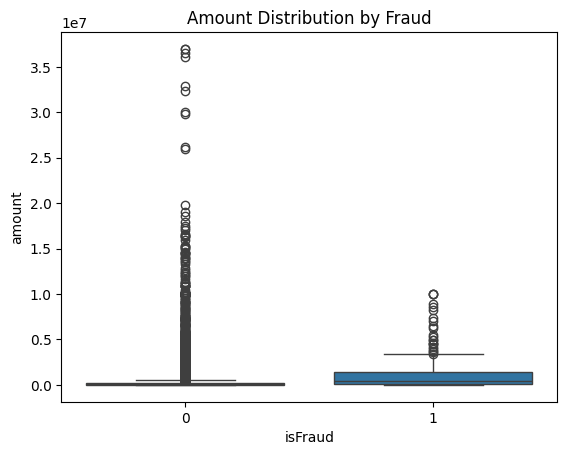

In [22]:
plt.figure()
sns.histplot(df["amount"], bins=50)
plt.title("Transaction Amount Distribution")
plt.show()

plt.figure()
sns.boxplot(x="isFraud", y="amount", data=df)
plt.title("Amount Distribution by Fraud")
plt.show()

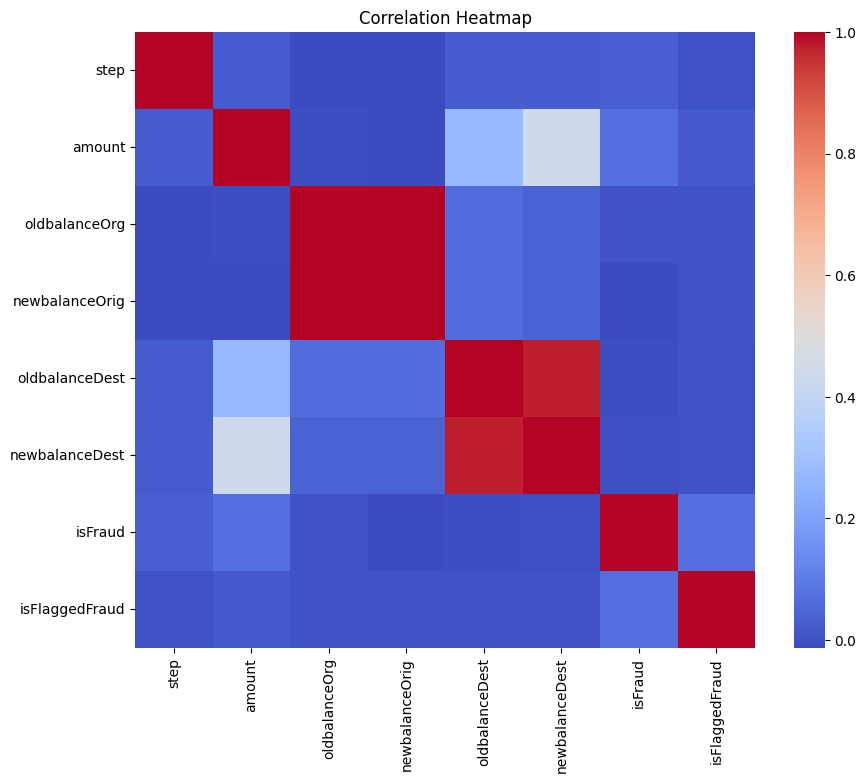

In [23]:
numeric_cols = df.select_dtypes(include=np.number)

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [7]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


df = pd.read_csv(r"C:\Users\MAITHILI\Gen-AI_FraudGuard\Datasets\paysim_sample.csv")

df.reset_index(inplace=True)
df.rename(columns={"index": "transaction_id"}, inplace=True)

df["balance_delta_org"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balance_delta_dest"] = df["newbalanceDest"] - df["oldbalanceDest"]



In [8]:
df.head()

,transaction_id,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balance_delta_org,balance_delta_dest
0,0,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0,-330218.42,-330218.42
1,1,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0,11647.08,0.00
2,2,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0,-152264.21,-152264.21
3,3,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0,0.00,1551760.63
4,4,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0,-78172.30,-78172.30


In [9]:
df = pd.get_dummies(df, columns=["type"], drop_first=True)

feature_cols = [
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",
    "balance_delta_org",
    "balance_delta_dest"
]

X = df[feature_cols]


#Isolation Forest Model

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("iforest", IsolationForest(
        n_estimators=200,
        contamination=0.02,
        random_state=42,
        n_jobs=-1
    ))
])

pipeline.fit(X)

# Binary anomaly flag
df["ml_anomaly_flag"] = (pipeline.predict(X) == -1).astype(int)

# Continuous anomaly score
df["ml_fraud_score"] = -pipeline.score_samples(X)

# Normalize ML score to 0–1
df["ml_fraud_score"] = (
    (df["ml_fraud_score"] - df["ml_fraud_score"].min()) /
    (df["ml_fraud_score"].max() - df["ml_fraud_score"].min())
)



In [10]:
df.head()

,transaction_id,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balance_delta_org,balance_delta_dest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,ml_anomaly_flag,ml_fraud_score
0,0,278,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0,-330218.42,-330218.42,False,False,False,False,0,0.256915
1,1,15,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0,11647.08,0.00,False,False,True,False,0,0.003595
2,2,10,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0,-152264.21,-152264.21,False,False,False,False,0,0.107625
3,3,403,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0,0.00,1551760.63,False,False,False,True,0,0.495751
4,4,206,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0,-78172.30,-78172.30,False,False,False,False,0,0.224300


In [11]:

#Rule Engine

def rule_engine(row):
    score = 0
    reasons = []

    if row["balance_delta_org"] > 0 and row["newbalanceOrig"] == 0:
        score += 40
        reasons.append("Sender balance drained to zero")

    if row["type_TRANSFER"] == 1 or row.get("type_CASH_OUT", 0) == 1:
        score += 30
        reasons.append("High-risk transaction type")

    if row["amount"] > 200000:
        score += 30
        reasons.append("Large transaction amount")

    return score, "; ".join(reasons)

df[["rule_score", "rule_reasons"]] = df.apply(
    lambda row: pd.Series(rule_engine(row)), axis=1
)

# Normalize rule score
df["rule_score_norm"] = df["rule_score"] / 100


#Final Fraud Score

df["total_fraud_score"] = (
    0.6 * df["ml_fraud_score"] +
    0.4 * df["rule_score_norm"]
)

df["flagged_fraud"] = (df["total_fraud_score"] >= 0.8).astype(int)

df.to_csv(r"C:\Users\MAITHILI\Gen-AI_FraudGuard\Datasets\paysim_processed.csv", index=False)

print("Preprocessing complete. File saved.")

Preprocessing complete. File saved.
